In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
% matplotlib inline

### 数据处理

In [3]:
train = pd.read_csv('data/census-income.csv')
train

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1],
                                    size=(train.shape[0],))

train_indices = train[train.loc[:, "Set"] == "train"].index  # 训练数据集索引
valid_indices = train[train.loc[:, "Set"] == "valid"].index  # 验证数据集索引
test_indices = train[train.loc[:, "Set"] == "test"].index  # 测试数据集索引

In [5]:
nunique = train.nunique()
nunique

39                   73
 State-gov            9
 77516            21647
 Bachelors           16
 13                  16
 Never-married        7
 Adm-clerical        15
 Not-in-family        6
 White                5
 Male                 2
 2174               119
 0                   92
 40                  94
 United-States       42
 <=50K                2
Set                   3
dtype: int64

In [6]:
types = train.dtypes
types

39                 int64
 State-gov        object
 77516             int64
 Bachelors        object
 13                int64
 Never-married    object
 Adm-clerical     object
 Not-in-family    object
 White            object
 Male             object
 2174              int64
 0                 int64
 40                int64
 United-States    object
 <=50K            object
Set               object
dtype: object

In [7]:
categorical_columns = []  # 分类特征
categorical_dims = {}  # 分类特征和该特征唯一值数量
for col in train.columns:
    # 分类特征处理
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()  # 标签二值化
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        # 非分类特征缺失值处理
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

print(categorical_columns)
print(categorical_dims)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3
['39', ' State-gov', ' Bachelors', ' 13', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0', ' 40', ' United-States', ' <=50K', 'Set']
{'39': 73, ' State-gov': 9, ' Bachelors': 16, ' 13': 16, ' Never-married': 7, ' Adm-clerical': 15, ' Not-in-family': 6, ' White': 5, ' Male': 2, ' 2174': 119, ' 0': 92, ' 40': 94, ' United-States': 42, ' <=50K': 2, 'Set': 3}


In [8]:
# 标签处理
target = ' <=50K'
train.loc[train[target] == 0, target] = "wealthy"
train.loc[train[target] == 1, target] = "not_wealthy"

In [9]:
unused_feat = ['Set']

# 特征
features = [col for col in train.columns if col not in unused_feat + [target]]

# 分类特征id
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

# 每个分类特征唯一值数量
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [10]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [11]:
### TabNetClassifier模型

In [12]:
clf = TabNetClassifier(
    # 分类特征索引列表;默认值[]
    cat_idxs=cat_idxs,
    # 每个分类特征唯一值数量;默认值[]
    cat_dims=cat_dims,
    # pytorch优化器;默认torch.optim.Adam
    optimizer_fn=torch.optim.Adam,
    # pytorch优化器参数
    optimizer_params=dict(lr=2e-2),
    # pytorch学习率调整
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    # pytorch学习率调整对于参数
    scheduler_params={"step_size": 50,  # how to use learning rate scheduler
                      "gamma": 0.9},
    # this is the masking function to use for selecting features.
    # (default='sparsemax') Either "sparsemax" or "entmax"
    mask_type='entmax'
)
clf

Device used : cuda


TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='entmax', input_dim=None, output_dim=None, device_name='auto')

In [13]:
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.metrics import Metric


class Gini(Metric):
    """自定义评价指标"""

    def __init__(self):
        self._name = "gini"   # write an understandable name here
        self._maximize = True

    def __call__(self, y_true, y_score):
        auc = roc_auc_score(y_true, y_score[:, 1])
        return max(2 * auc - 1, 0.)


def my_loss_fn(y_pred, y_true):
    """自定义损失函数"""
    softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
    logloss = (1 - y_true) * torch.log(softmax_pred[:, 0])
    logloss += y_true * torch.log(softmax_pred[:, 1])
    return -torch.mean(logloss)

In [14]:

clf.fit(
    X_train=X_train,
    y_train=y_train,
    # List of eval tuple set (X, y).
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    # List of eval set names.
    eval_name=['train', 'valid'],
    # List of evaluation metrics.
    # The last metric is used for early stopping.
    # binary classification metrics : 'auc', 'accuracy', 'balanced_accuracy', 'logloss'
    # multiclass classification : 'accuracy', 'balanced_accuracy', 'logloss'
    # regression: 'mse', 'mae', 'rmse', 'rmsle'
    eval_metric=['auc', Gini],
    # loss function for training (default to mse for regression and cross entropy for classification)
    loss_fn=F.cross_entropy,  # 使用pytorch其他损失函数
    # Maximum number of epochs for trainng.
    max_epochs=1000,  # 默认值200
    # Number of consecutive epochs without improvement before performing early stopping.
    patience=20,  # 默认值15
    # Number of examples per batch. Large batch sizes are recommended.
    batch_size=1024,  # 默认值1024
    # Number or workers used in torch.utils.data.Dataloader
    num_workers=2,  # 默认值0
    # Only for TabNetClassifier Sampling parameter 0 : no sampling 1 : automated sampling with inverse class occurrences dict : keys are classes, values are weights for each class
    weights=1,
    # Whether to drop last batch if not complete during training
    drop_last=False  # 默认值false
)

epoch 0  | loss: 0.65273 | train_auc: 0.78114 | train_gini: 0.56229 | valid_auc: 0.77691 | valid_gini: 0.55383 |  0:00:54s
epoch 1  | loss: 0.5164  | train_auc: 0.83202 | train_gini: 0.66404 | valid_auc: 0.833   | valid_gini: 0.66601 |  0:01:06s
epoch 2  | loss: 0.47577 | train_auc: 0.8513  | train_gini: 0.70261 | valid_auc: 0.85408 | valid_gini: 0.70816 |  0:01:17s
epoch 3  | loss: 0.45895 | train_auc: 0.86537 | train_gini: 0.73074 | valid_auc: 0.86897 | valid_gini: 0.73794 |  0:02:14s
epoch 4  | loss: 0.44634 | train_auc: 0.87919 | train_gini: 0.75838 | valid_auc: 0.88239 | valid_gini: 0.76477 |  0:02:25s
epoch 5  | loss: 0.41464 | train_auc: 0.89099 | train_gini: 0.78198 | valid_auc: 0.89471 | valid_gini: 0.78942 |  0:03:00s
epoch 6  | loss: 0.40493 | train_auc: 0.90243 | train_gini: 0.80486 | valid_auc: 0.90672 | valid_gini: 0.81343 |  0:03:12s
epoch 7  | loss: 0.39806 | train_auc: 0.90506 | train_gini: 0.81011 | valid_auc: 0.91094 | valid_gini: 0.82189 |  0:03:23s
epoch 8  | loss:

### 结果分析

In [15]:
clf.history

{'loss': [0.6527312830075641, 0.5164037395422933, 0.47577391942955705, 0.45894655416095514, 0.44633713575234435, 0.41463638440414424, 0.4049300554940308, 0.3980554655357981, 0.38613166824971107, 0.3795015929806129, 0.3632677677265279, 0.3624490971337946, 0.35900332112965094, 0.3559914542465265, 0.36416670991874944, 0.3544659732494741, 0.3542008049671044, 0.34880175513908723, 0.33986596312447426, 0.34778601444242846, 0.3429174668948991, 0.3408406301926493, 0.33445159129908886, 0.3393579038128908, 0.3316877617730316, 0.329955586351227, 0.33561875357087184, 0.33464336013376345, 0.3335836631316528, 0.32772324105520506, 0.32780725670051325, 0.3257896585852592, 0.31872780834318004, 0.3283717092614556, 0.3216992646714477, 0.3201786294079252, 0.3250538755568563, 0.3288430693357086, 0.3192818454194382, 0.3141955406474217, 0.3202291641164286, 0.31476216261916384, 0.3163272652554972, 0.3212792548663863, 0.31766024057909287, 0.32685947022130707, 0.32559548460220133, 0.32098500167177857, 0.31971598

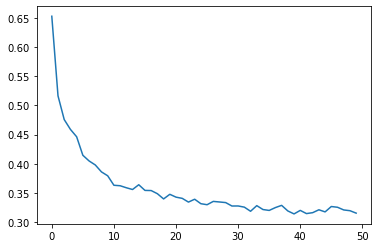

In [16]:
# plot losses
plt.plot(clf.history['loss'])

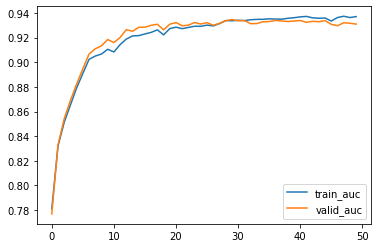

In [17]:
# plot auc
plt.plot(clf.history['train_auc'], label="train_auc")
plt.plot(clf.history['valid_auc'], label="valid_auc")
plt.legend()

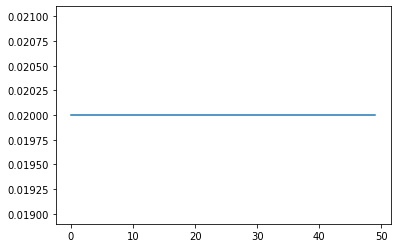

In [18]:
# plot learning rates
plt.plot(clf.history['lr'])

In [19]:
dataset_name = 'census-income'
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:, 1], y_true=y_test)

preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:, 1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.86938897504355
FINAL TEST SCORE FOR census-income : 0.9183272845772344


In [20]:
clf.predict(X_test)

array(['wealthy', 'wealthy', 'wealthy', ..., 'wealthy', 'wealthy',
       'wealthy'], dtype='<U11')

In [21]:
# 特征的想对重要性
clf.feature_importances_

array([0.0818902 , 0.07788036, 0.00104959, 0.1942333 , 0.02534461,
       0.26021981, 0.03839474, 0.07318998, 0.01446298, 0.03290445,
       0.05575965, 0.00302245, 0.13298253, 0.00866537])

### 保存和加载模型

In [22]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [27]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model('tabnet_model_test_1.zip')

Device used : cuda
Device used : cuda


In [28]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:, 1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")
print(loaded_clf.predict(X_test))


FINAL TEST SCORE FOR census-income : 0.9183272845772344
['wealthy' 'wealthy' 'wealthy' ... 'wealthy' 'wealthy' 'wealthy']
